In [74]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [75]:
load_dotenv()

True

In [76]:
generator_llm = ChatOpenAI(model="gpt-4o")
evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
optimiser_llm = ChatOpenAI(model="gpt-4o")

In [77]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [78]:
structured_model = evaluator_llm.with_structured_output(TweetEvaluation)

In [79]:
# state
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add] # type: ignore
    feedback_history: Annotated[list[str], operator.add] # type: ignore
    # to append to the list instead of overwriting it

In [80]:
def generate_tweet(state: TweetState) -> TweetState:
    
    messages = [
        SystemMessage(content="You are a smart and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, authentic, and bold tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational reality, clever, smart and bold statements.
- Use simple, day to day english
""")
    ]
    
    tweet = generator_llm.invoke(messages).content
    
    return {'tweet': tweet, 'tweet_history': [tweet]} # type: ignore

In [81]:
def evaluate_tweet(state: TweetState) -> TweetState:
    # prompt
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on originality, boldness, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. boldness – Did it genuinely make you think, re-evaluate, or see things differently?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like anyday tweet
            - Dont end with generic, throwaway, or deflating lines that everyone have heard millions of times (e.g., “The Magic that you are looking for is in the work you are avoiding”)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
        """)]
    
    response = structured_model.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]} # type: ignore

In [82]:
def optimise_tweet(state: TweetState) -> TweetState:
    
    messages = [
        SystemMessage(content="You punch up tweets for virality, authenticity and boldness based on given feedback."),
        HumanMessage(content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """)]
    
    response = optimiser_llm.invoke(messages).content
    iteration = state['iteration'] + 1
    
    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]} # type: ignore

In [83]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [84]:
# create graph
graph = StateGraph(TweetState)

# add nodes
graph.add_node('generate_tweet', generate_tweet)
graph.add_node('evaluate_tweet', evaluate_tweet)
graph.add_node('optimise_tweet', optimise_tweet)

# add edges
graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet', route_evaluation, {'approved': END, 'needs_improvement': 'optimise_tweet'})
graph.add_edge('optimise_tweet', 'evaluate_tweet')

# compile graph
workflow = graph.compile()

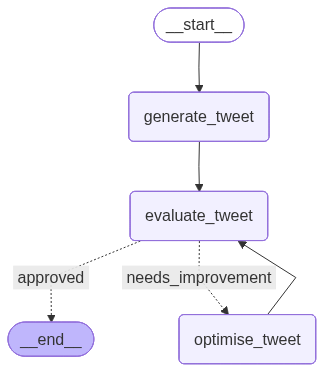

In [85]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [86]:
# initial state
initial_state = {
    'topic': 'Humanity, AI and Spirituality in the Digital Age',
    'iteration': 1,
    'max_iteration': 3
}

In [87]:
# final State
final_state = workflow.invoke(initial_state) # type: ignore
final_state

{'topic': 'Humanity, AI and Spirituality in the Digital Age',
 'tweet': "In the digital age, we're crafting a future where AI sharpens, spirituality grounds, and humanity leads the rhythm. Together, they're remixing reality into a harmonious symphony of code and conscience. Welcome to the #DigitalRenaissance! 🔥🤖✨",
 'evaluation': 'needs_improvement',
 'feedback': "This tweet attempts to blend themes of AI and spirituality in a creative way, but ultimately falls flat on originality, as similar ideas have been over-explored in discussions about technology and humanity. While it has a poetic quality and catches attention with its imagery, it lacks punchiness and could benefit from brevity to enhance impact. The concluding phrase, 'Welcome to the #DigitalRenaissance!', feels clichéd and diluted, which detracts from the overall boldness of the message. Although it is within the character limit, the execution feels more like a verbose monologue than a compelling tweet, making it less likely 

In [88]:
for tweet in final_state['tweet_history']:
    print(tweet)

In the digital age, humanity, AI, and spirituality coexist like a quirky trio at a cosmic party. AI helps with precision, Spirituality reminds us to breathe, and Humanity holds the dance floor. Together, they craft a future where pixels meet profound purpose. #DigitalBalance
In the digital age, humanity, AI, and spirituality aren't just party guests—they're the magic behind the beat. AI sharpens, spirituality grounds, and humanity dances. Together, they remix our world into a future where code meets conscience. 🚀✨ #DigitalRenaissance
In the digital age, we're crafting a future where AI sharpens, spirituality grounds, and humanity leads the rhythm. Together, they're remixing reality into a harmonious symphony of code and conscience. Welcome to the #DigitalRenaissance! 🔥🤖✨


In [89]:
for feedback in final_state['feedback_history']:
    print(feedback)

While the tweet attempts to merge technology and spirituality in a creative metaphor, it lacks true originality and boldness, as similar themes have been explored extensively. The imagery of a 'cosmic party' feels clichéd, and the message doesn't provoke significant thought. It stretches slightly in length and could benefit from more punchiness to engage the audience better. Overall, the tweet reads like something seen before, with a generic wrap-up that doesn’t inspire action or reflection.
While the tweet attempts to blend intricate themes of humanity, AI, and spirituality in a poetic manner, it ultimately comes across as convoluted and lacks the punchiness needed to grab attention. The metaphor of party guests feels clichéd and doesn't add much originality, making it seem like a derivative thought rather than a fresh perspective. Additionally, the length and complexity diminish its viral potential, as the audience might find it hard to engage with. Overall, it could benefit from a c